<a href="https://colab.research.google.com/github/oroobyaseen/coursera.exercises/blob/gh-pages/Xgboost%2BVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install xgboost  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

import os
import seaborn as sns
from sklearn.utils import shuffle   
from keras.applications.vgg16 import VGG16

In [4]:
from tensorflow.keras.layers import BatchNormalization

In [5]:
labels = ['Meningioma', 'Glioma', 'Pituitary tumor']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
          try:
              img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

              resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
              data.append([resized_arr, class_num])
          except Exception as e:
                print(e)
       
    return np.array(data),  np.array(labels)

In [6]:
#Now we can easily fetch our train and validation data.
train = get_data('/content/drive/MyDrive/Lec/Train')
val = get_data('/content/drive/MyDrive/Lec/Val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [8]:
training_dir = '/content/drive/MyDrive/Lec/Train'
validation_dir = '/content/drive/MyDrive/Lec/Val'

In [9]:
# useful for getting number of files
image_files = glob(training_dir + '/*/*.jp*g')
valid_image_files = glob(validation_dir + '/*/*.jp*g')

In [10]:
# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 3


In [11]:
class_names = ['Meningioma', 'Glioma', 'Pituitary tumor']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [12]:
#Display Progress
from tqdm import tqdm

Defining Classes & Loading Data

In [13]:
#Function to Load Images & Labels
def load_data():
    
    datasets = ['/content/drive/MyDrive/Lec/Train', '/content/drive/MyDrive/Lec/Val']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [14]:
#Loading Data (Training & Test Dataset)
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/Lec/Train


100%|██████████| 750/750 [00:04<00:00, 151.91it/s]


Loading /content/drive/MyDrive/Lec/Val


100%|██████████| 286/286 [00:01<00:00, 186.87it/s]


Data Visualisation & Pre-Processing

In [15]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [16]:
#Label Dataset Shape
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2456
Number of testing examples: 616
Each image is of size: (224, 224)


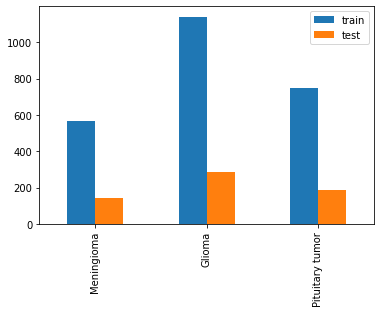

In [17]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar()
plt.show()

In [18]:
#Scale the data
train_images = train_images / 255.0
test_images = test_images / 255.0

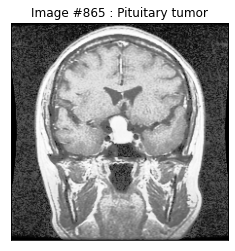

In [19]:
#Visualise the data [random image from training dataset]

def display_random_img(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    

display_random_img (class_names, train_images, train_labels)

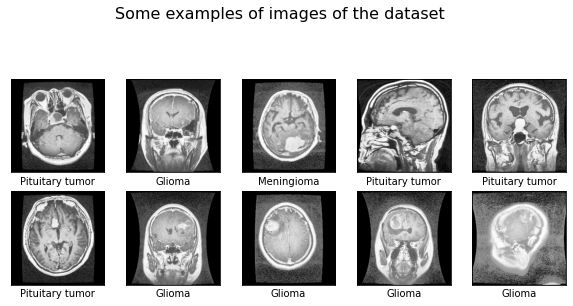

In [20]:
def display_examples(class_names, images, labels):
   
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)


In [21]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)


In [22]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [23]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [24]:
IMAGE_SIZE = 224

In [30]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
x = Flatten()(VGG_model.output)
prediction =Dense ( 3, activation='softmax')(x)
model = Model(inputs=VGG_model.input, outputs=prediction)
model.summary()  #Trainable parameters will be 0

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [31]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [32]:

r = model.fit(
    x_train, y_train, 
 
  validation_data=(x_test, y_test),
  epochs=20)

Epoch 1/20


ValueError: ignored

In [ ]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding


XGBClassifier(objective='multi:softprob')

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.9188311688311688


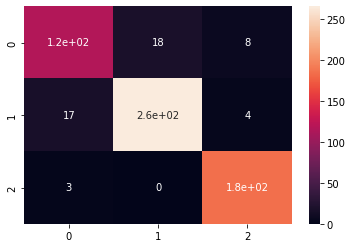

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  [2]
The actual label for this image is:  2


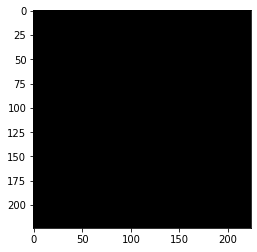

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

